In [0]:
# 我們會從https下載資料庫, MAC電腦需要加入以下兩行, 才不會把對方的ssl憑證視為無效
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

將import的對象改換成fashion_mnist

In [1]:
from keras.datasets import fashion_mnist
# 回傳值: ((訓練特徵, 訓練目標), (測試特徵, 測試目標))
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()

Using TensorFlow backend.


熟悉的shape，60000筆28 $\times$ 28的資黑白照片

In [2]:
x_train.shape

(60000, 28, 28)

In [0]:
labels = ['t-shirt', 'trouser', 
          'pullover', 'dress', 
          'coat', 'sandal', 
          'shirt', 'sneaker', 
          'bag', 'ankle boots']

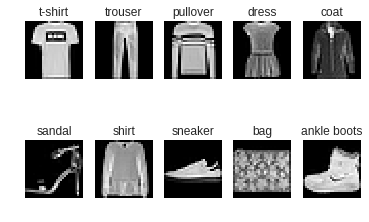

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
# 準備在裡面塞入{0:T-Shirt圖片, 1:褲子圖片...}共十張
samples = {}
for (idx, label) in enumerate(y_train):
    # 取出0-9, 如果那類圖片已經不在字典裡, 就加入進去
    if not label in samples:
        samples[label] = x_train[idx]
    # 如果已經有十個了, 代表每種都挑出一個了, 跳出
    if len(samples) == 10:
        break 
# 走過字典的時候拿出的是key的部分, 也就是0-9
# 我使用sorted排列為了依照順序印出
for key in sorted(samples):
    # 把大圖切成2 * 5小圖, 編號為
    # 1, 2, 3, 4, 5
    # 6, 7, 8, 9, 10
    # 所以利用key + 1得到對應的小圖編號
    plt.subplot(2, 5, key + 1)
    # 打上對應的title
    plt.title(labels[key])
    plt.axis('off')
    plt.imshow(samples[key], cmap='gray')

In [0]:
from keras.utils import np_utils
# reshape讓他從 32 * 32變成 784 * 1的一維陣列
# 讓我們標準化到-1~1區間
x_train_shaped = (x_train.reshape(60000, 784).astype("float32") - 127.5)/127.5
x_test_shaped = (x_test.reshape(10000, 784).astype("float32") - 127.5)/127.5

In [1]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization

random_dim = 100
generator = Sequential()
generator.add(Dense(256, input_dim=random_dim, 
                    activation='relu'))
generator.add(BatchNormalization())
generator.add(Dense(512, activation='relu'))
generator.add(BatchNormalization())
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer="adam")
generator.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
Total params: 562,704
Trainable params: 561,168
Non-trainable params: 1,536
_________________________________________________________________


In [2]:
from keras.layers import Dropout

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, 
                        activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(512, activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(256, activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer="adam")
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total para

In [0]:
from keras.models import Model
from keras.layers import Input

discriminator.trainable = False
gan_input = Input(shape=(random_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer="adam")
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               562704    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,022,929
Trainable params: 561,168
Non-trainable params: 1,461,761
_________________________________________________________________


In [0]:
import numpy as np

batch_size = 200
epoch_count = 100
for epoch in range(0, epoch_count):
    for batch_count in range(0, 300):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train_shaped[idx]

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        # 步驟0:讓創作家製造出fake image
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        gen_imgs = generator.predict(noise)

        # 步驟1-1:讓鑑賞家鑑賞對的image
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        # 步驟1-2:讓鑑賞家鑑賞錯的image
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = (d_loss_real + d_loss_fake) / 2

        noise = np.random.normal(0, 1, (batch_size, random_dim))
        # 步驟2:訓練創作家的創作能力
        g_loss = gan.train_on_batch(noise, valid)
    if (epoch + 1) % 10 == 0:
        dash = "-" * 15
        print(dash, "epoch", epoch + 1, dash)
        print("Discriminator loss:", d_loss)
        print("Generator loss:", g_loss)


--------------- epoch 10 ---------------
Discriminator loss: 0.41798272728919983
Generator loss: 1.7886623
--------------- epoch 20 ---------------
Discriminator loss: 0.40436792373657227
Generator loss: 1.9079899
--------------- epoch 30 ---------------
Discriminator loss: 0.4095344543457031
Generator loss: 1.7306284
--------------- epoch 40 ---------------
Discriminator loss: 0.38015812635421753
Generator loss: 1.7655674
--------------- epoch 50 ---------------
Discriminator loss: 0.4015156626701355
Generator loss: 1.8157192
--------------- epoch 60 ---------------
Discriminator loss: 0.36917126178741455
Generator loss: 1.8908474
--------------- epoch 70 ---------------
Discriminator loss: 0.41656142473220825
Generator loss: 1.9993997
--------------- epoch 80 ---------------
Discriminator loss: 0.3950040638446808
Generator loss: 1.9153638
--------------- epoch 90 ---------------
Discriminator loss: 0.3120790123939514
Generator loss: 2.0849042
--------------- epoch 100 ---------------

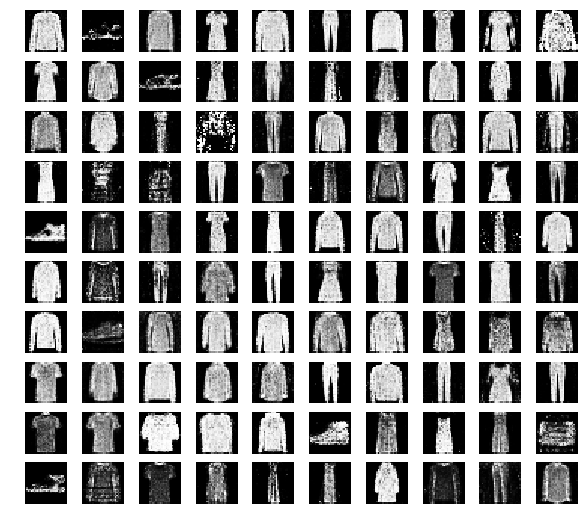

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
# 採用100個samples
examples = 100
# 100個samples * 100靈感維度
noise = np.random.normal(0, 1, (examples, random_dim))
gen_imgs = generator.predict(noise)

# 將-1-1轉換回0-1
plt.figure(figsize=(10, 10))
gen_imgs = 0.5 * gen_imgs + 0.5
gen_imgs = gen_imgs.reshape(examples, 28, 28)

# 算出寬度和長度
w = 10
# 怕有餘數, 所以取整數後多+1
h = int(examples / w) + 1
for i in range(0, examples):
    plt.subplot(h, w, i + 1)
    plt.axis('off')
    plt.imshow(gen_imgs[i], cmap='gray')